In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


In [62]:
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")

# Set the sampling rate and the filter cutoff frequencies
fs = 250
low_cutoff = 6
high_cutoff = 30

#Create two dataframes from eeg_data the first is the first column which is the timestamp and the second is the remaiing columns which are the EEG data
eeg_data_timestamp = eeg_data.iloc[:,0]
eeg_data_eeg = eeg_data.iloc[:,1:]

# Create an array of the EEG data
eeg_array = eeg_data_eeg.to_numpy() # 40672 rows x 8 columns (channels)

eeg_array = eeg_array.T # 8 rows (channels) x 40672 columns (samples)




In [63]:
def rls_filter(eeg_data, target_freq, lambda_=0.98):
    """
    Implements the RLS (Recursive Least Squares) adaptive filter for SSVEP detection.

    Args:
        eeg_data (ndarray): Input EEG data of shape (n_channels, n_samples).
        target_freq (float): Target frequency of the SSVEP stimulus.
        lambda_ (float, optional): Forgetting factor. Default is 0.98.

    Returns:
        ndarray: Filtered data of shape (n_channels, n_samples).
    """
    n_channels, n_samples = eeg_data.shape
    n = int(np.round(target_freq * n_samples / 250))  # index corresponding to the target frequency

    # Initialize filter coefficients, P matrix, and estimated output
    w = np.zeros((n_channels, 1))
    P = np.eye(n_channels) / 0.001
    filtered_data = np.zeros_like(eeg_data)

    # Apply RLS filter
    for t in range(n_samples):
        x = eeg_data[:, t].reshape(-1, 1)  # current input sample
        y = np.dot(w.T, x)  # estimated output
        e = eeg_data[:, t] - y  # error signal
        k = np.dot(P, x) / (lambda_ + np.dot(np.dot(x.T, P), x))  # Kalman gain
        w = w + k * e  # filter coefficients update
        P = (1 / lambda_) * (P - np.dot(np.dot(k, x.T), P))  # P matrix update
        filtered_data[:, t] = y.flatten()  # store filtered output

    return filtered_data

(8, 40672)


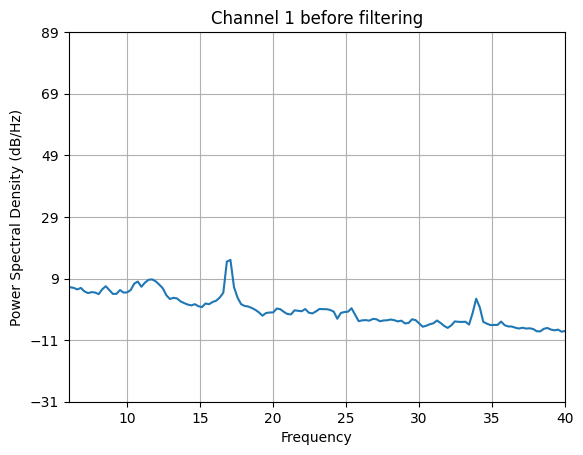

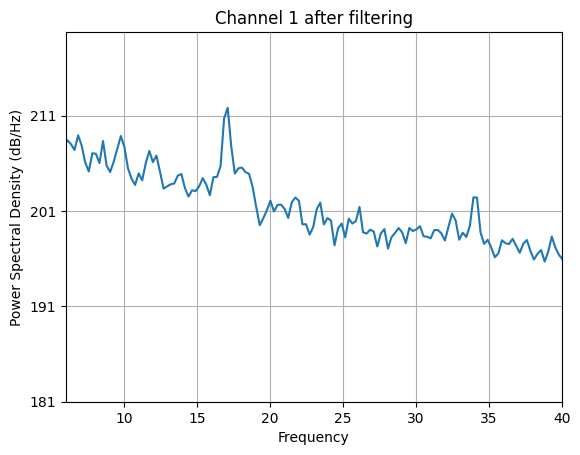

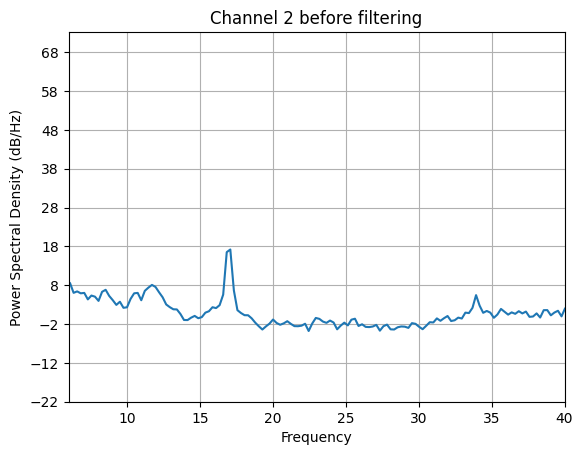

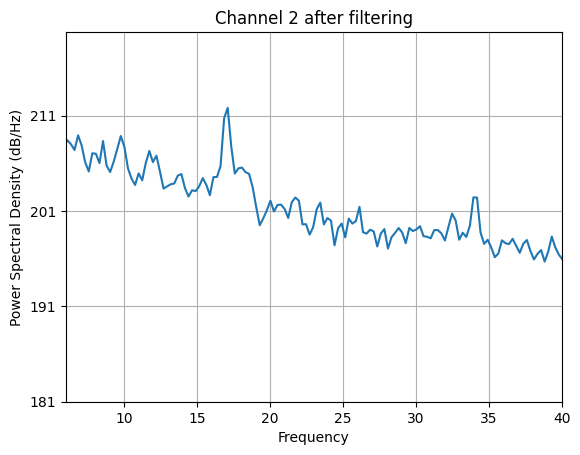

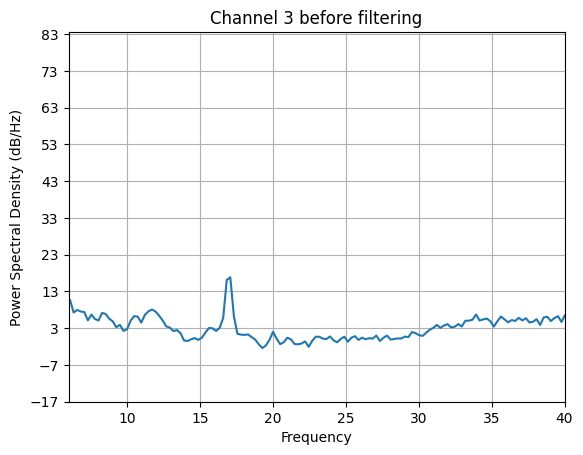

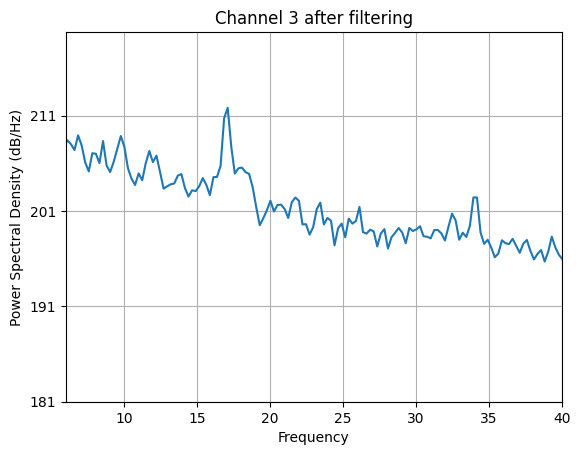

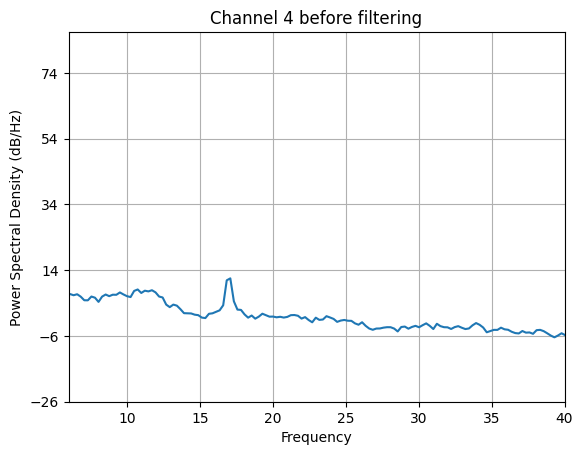

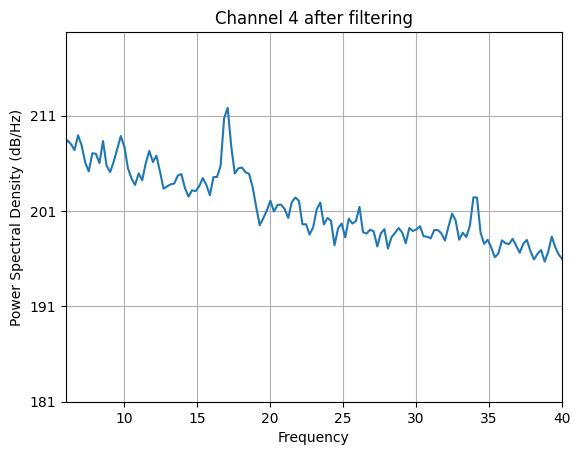

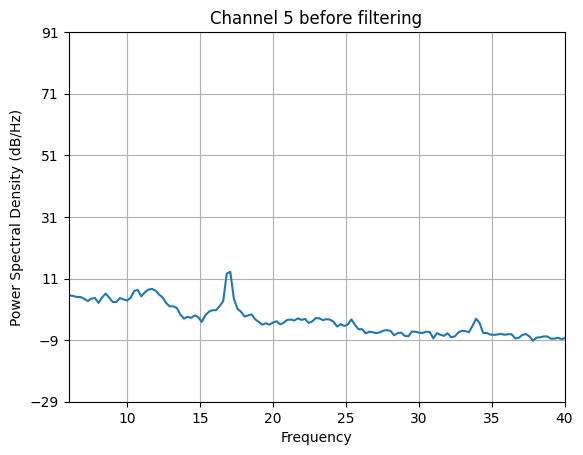

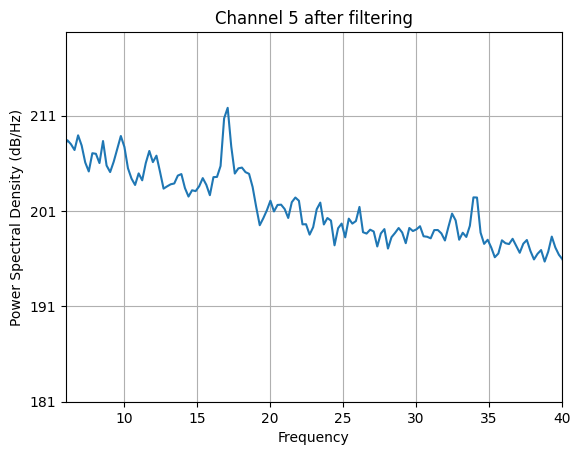

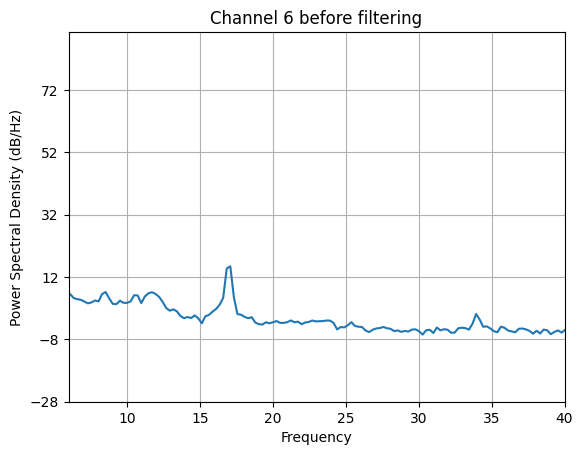

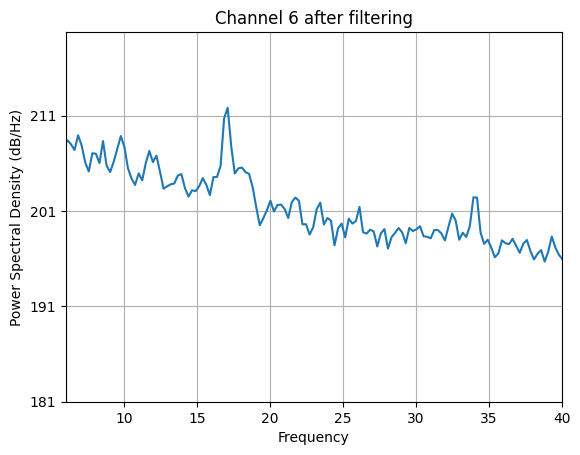

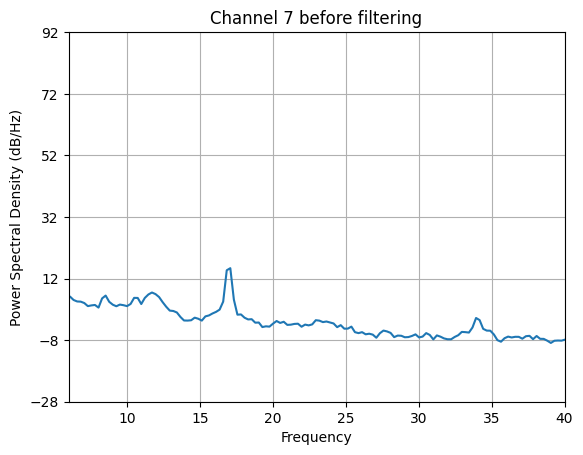

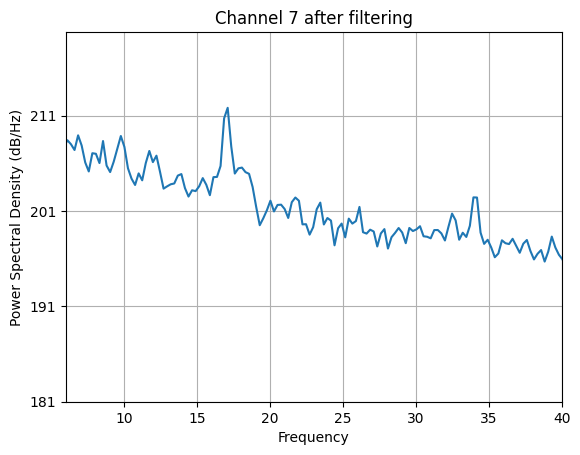

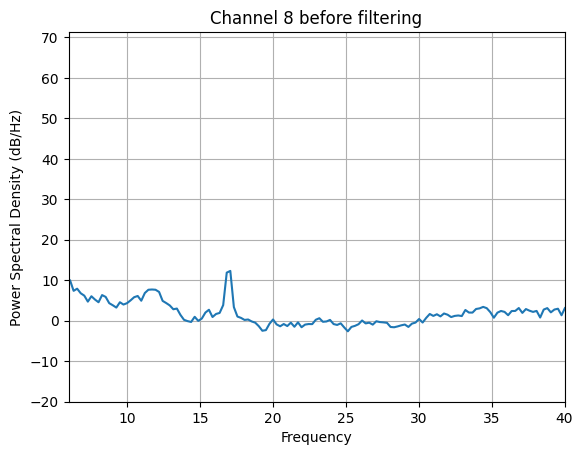

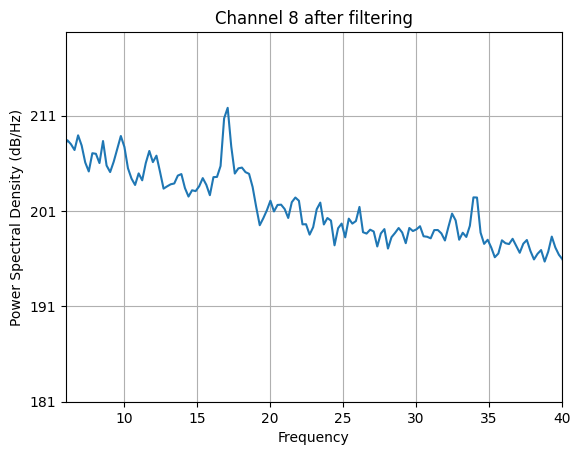

In [64]:
rls_data = rls_filter(eeg_array, 13)

print(rls_data.shape)

#Plot the data for each channel seperately before and after filtering
# for i in range(8):
#     plt.figure()
#     plt.plot(eeg_array[i,:])
#     plt.title("Channel "+str(i+1)+" before filtering")
#     plt.figure()
#     plt.plot(rls_data[i,:])
#     plt.title("Channel "+str(i+1)+" after filtering")
#     plt.show

#Plot the power spectrum of the data before and after filtering ranging from 0 to 50 Hz
for i in range(8):
    plt.figure()
    plt.psd(eeg_array[i,:], Fs=250, NFFT=1024)
    plt.xlim(6,40)
    plt.title("Channel "+str(i+1)+" before filtering")    
    plt.figure()
    plt.psd(rls_data[i,:], Fs=250, NFFT=1024)
    plt.xlim(6,40)
    plt.title("Channel "+str(i+1)+" after filtering")
    plt.show

